In [1]:
import numpy as np
import matplotlib.pyplot as plt
from velocity_functions import *
from scipy.integrate import odeint
# %matplotlib inline

radius  = {'RBC':3.75e-6,'WBC':6.25e-6,'plate':1.19e-6,'bac':2.5e-6} # radius in meters
density = {'RBC':1093,   'WBC':1066,   'plate':1053,   'bac': 1025 } # density in kg/m3
sedcoef = {'RBC':12e-7,  'WBC':1.2e-7, 'plate':0.032e-7} # Sedimentation coefficient in s (Van Wie)
viscosity = {'plas':0.0026} # viscosity of plasma in kg/m s
help(porosity)

Help on function porosity in module velocity_functions:

porosity(concs, power=1, radii=(3.75e-06, 2.5e-06))
    Calculates the apparent porosity for j particle types
    -------------------------------------------------------------------------
    inputs:
        concs: jxi array of particle concentrations. Values are summed by column
               j: rows: number of cell types 
               i: cols: number of grid points
               
        power: scalar exponent for the porosity (Can be made into f(cell type))
               Used in empirical correlations: see Masliyah articles quoted in
               Patwardhan and Tien 1985
        
        radius: tuple of j cell radii
    -------------------------------------------------------------------------
    outputs:
        porosity: jxi array of apparent porosities for each input composition
        
    Notes: When plotting a single row of concentrations, change the shape of
           conc[i,:] from (j,) to (j,1) using np.atle

# Velocity and Integration schemes
The current scheme integrates a 1D scalar conservation law using zero flux B.C. at both walls.
To Do:
1. Come up with a multicomponent flux function using the Lerche 2001 model.
2. plot $(u_{plasma}-u_{bac})$ vs. $\alpha_{RBC}$ to find where backflow occurs.
3. Write upwinding function for two independent waves over x
  1. Start decoupled. Then couple
  2. Include backflow and conditional statements for upwinding.

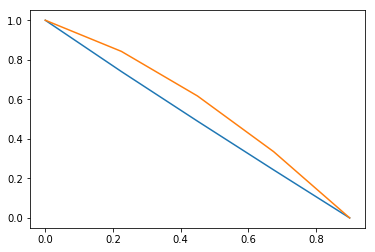

(2, 5)

In [56]:
# Write multicomponent velocity function
def c_sys(α,ndefs,αmaxs):
    '''
    Custom velocity function that computes the sedimentation velocity of j
    particle types using the Lerche 2001 form
    Inputs:
        α:     ixj array of cell concentrations
        ndefs: tuple of deformation parameters of length j
    Outputs:
        c: ixj array of cell velocities
    '''
    n_cells = len(ndefs)
    nx      = np.shape(α)[1]
    
    α_tot = np.sum(α,axis=0)
    c_out = np.empty((n_cells,nx))
    
    for j in range(n_cells):
        c_out[j,:] = np.nan_to_num((1-(α[j,:]/α_tot)/αmaxs[j])**ndefs[j])
    return c_out

RBC = np.linspace(0,0.9,5)
bac = np.linspace(0,0.1,5)
cells = np.vstack((RBC,bac))

# plt.plot(RBC,c_sys(cells,ndefs=(2,1),αmaxs=(1,1)).T)
# plt.show()
# c_sys(cells,ndefs=(2,1),αmaxs=(1,1))

speeds = porosity(cells)
plt.plot(RBC.T,speeds.T)
plt.show()
np.shape(speeds)

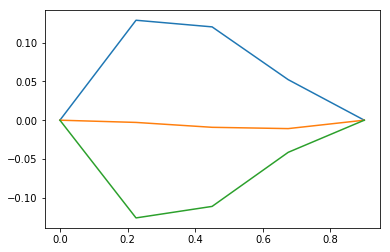

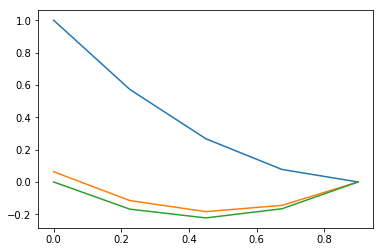

array([[ 1.        ,  0.57257233,  0.26730365,  0.07742171,  0.        ],
       [ 0.0630303 , -0.11484032, -0.18335416, -0.14453443,  0.        ],
       [ 0.        , -0.16794369, -0.22223787, -0.16567829,  0.        ]])

In [87]:
def get_c(α,c_rel,mode=None,**kwargs):
    '''
    Return non-dimensional velocity
    Inputs:
        α:     jxi array of cell concentrations
        c_rel: jx1 array of stokes velocities of j species normalized to RBCs
        mode:  (optional) hindered settling correction to use: type: string
    Outputs:
        c:     jxi array of velocity of j species corrected for concentration and
               normalized by the max stokes velocity of a RBC (i.e. the outer wall)
    '''
    try:
        if mode == 'porosity':
            hsc = porosity(α,**kwargs)
    
    except: # if no hindered settling correction chosed, return c_rel at each spatial point
        hsc = np.ones_like(α)
    
    c = c_rel*hsc
    return c

def get_q(α_cells,**kwargs):
    '''
    returns the speed and volumetric flux of j particle types
    inputs: jxi array (checkdims for consistency) of j particle concentrations.
    
    number of species and stokes velocity should come from class attributes
    output: 
    '''
    # assign slip velocity of cells relative to fluid using HSC
    c_cells_slip = get_c(α_cells,**kwargs)
    
    # calculate plasma α, initialize array of plasma speeds (0), and combine with cell values
    α_plasma = 1-np.sum(α_cells,axis=0)
    c_plasma = np.zeros(np.shape(α_cells[1]))
    α,c_slip = [np.vstack((species,fluid)) for species,fluid in zip((α_cells,c_cells_slip),(α_plasma,c_plasma))]
    
    # compute absolute velocities (and flux) using Davis and Gecol 1994 equation 2
    c_avg_slip = np.sum(c_slip*α,axis=0)
    c_abs = c_slip - c_avg_slip
    q_abs = α*c_abs
    
    return q_abs,c_abs

q_abs,c_abs = get_q(cells,c_rel=U0_rel,mode='porosity')
plt.plot(RBC.T,q_abs.T)
plt.show()
plt.plot(RBC.T,c_abs.T)
plt.show()
c_abs

In [78]:
# Experimental parameters
α_rbc_0 = 0.4
RPM = 3000
rcells = (6.25e-6,2.5e-6)
ρcells = (1090,1050)

tend   = 1      # s
ntimes = 50   
ngrd   = 50
r1     = 0.057  # m
r2     = 0.06   # m
rs     = np.linspace(r1,r2,4)
L      = r2-r1  # m

#### Non-dimensionalize variables
U0 = stokes(RPM,r2,rcells,ρcells) # stokes velocity of each cell type at the max radius (assumes stokes is not f(r))
U0_rel = (U0/U0[0])[:,np.newaxis] # normalize species stokes by RBC at the max radius. Shape=(2,1) for get_c function

T  = L/U0[0]     # seconds it takes to traverse length going at max speed.
cycles = tend/T  # 

# Time and space grids                  Dimensions
times  = np.linspace(0,cycles,ntimes) # 
Δt     = tend/ntimes                  # s
ngrdf  = ngrd+1                       #
xf     = np.linspace(r1/r2,1,ngrdf)   # 
Δx     = xf[1]-xf[0]                  # 
x      = (xf[1:] + xf[:-1])/2         #

# α0  = np.ones(ngrd)*α_rbc_0
# αall,diag = odeint(godunov, α0, times,args=(x,spin),full_output=1)

r is a scalar


In [ ]:
L,U0_rel,T,tend/T

In [ ]:
cfl = Δt*get_c(0.35,r1,spin)/Δx; cfl

In [ ]:
# %matplotlib inline
fig = plt.figure()
fig.figsize=(10,10)

color = plt.get_cmap('Reds')
colors = iter(color(np.linspace(0,1,ntimes)))
for j in range(ntimes):
    plt.plot(x,αall[j,:],color=next(colors))

plt.xlabel('position')
plt.ylabel(r'$\alpha$')
plt.xlim([r1/r2,1]);
plt.show()

### Animations

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation',html='html5')
%matplotlib inline

fig, ax = plt.subplots()
ax.set_xlim([r1/r2,1])
ax.set_ylim([0,1])
line, = ax.plot([],[])

def init():
    line.set_data([],[])
    ax.set_xlabel('Normalized Distance')
    ax.set_ylabel('Hematocrit')
    return (line,)
def animate(i):
    line.set_data(x,αall[i,:])
    line.set_color('red')
    return (line,)
anim = animation.FuncAnimation(fig,animate,init_func=init,
                               frames=ntimes,interval=Δt*1000,blit=True)

anim
# anim.save('wave_simulation.mp4')

### Completed steps:
1. non-dimensionalize code for time, flux, and velocity. I will follow Lerche 2001's non-dimensionalization
$$x^{*} = \frac{x}{L}$$
$$T = \frac{L}{U_{0}}$$
$$t^{*} = \frac{tU_{0}}{L} = \frac{t}{T}$$
$$u^{*} = \frac{u}{u_{0}}$$  

In [ ]:
def bc(inside,left_edge,right_edge):
    output       = np.zeros(ngrd+2)
    output[0]    = left_edge
    output[-1]   = right_edge
    output[1:-1] = inside
    return output

def godunov(α,t,r,cell_params):
    α_bc       = np.empty(ngrd+2)
    α_bc[0]    = 0.0
    α_bc[-1]   = 1.0
    α_bc[1:-1] = α

    r_bc       = np.empty(ngrd+2)
    r_bc[0]    = r[0] -Δx # be careful taking global variables!
    r_bc[-1]   = r[-1]+Δx
    r_bc[1:-1] = r
    
#     evaluate fluxes at each cell and initialize cell interfaces
    q = α_bc*get_c(α_bc,r_bc,cell_params) # I may need r_bc to be dimensional or not.
#     q = get_q(α_bc) It won't be that simple to go from scalar integration to system integration.
    qf = np.zeros(ngrdf)
    
    # apply Godunov flux at each cell interface
    for i in range(ngrdf):
        if α_bc[i] >= α_bc[i+1]:
            qf[i] = max(q[i],q[i+1])
        elif α_bc[i] <= 0 and 0 <= α_bc[i+1]:
            qf[i] = 0
        else:
            qf[i] = min(q[i],q[i+1])
    
    # apply upwinding scheme with the godunov interface fluxes
    dαdt = 1/Δx*(qf[:-1]-qf[1:])
    return dαdt